Load in required packages:

In [3]:
import pandas as pd
import numpy as np
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

%matplotlib inline
set_matplotlib_formats('pdf', 'svg')

# Dataset Summary
This project focuses on data from ATP matches in 2019 (obtained from https://github.com/JeffSackmann/tennis_atp). The dataset contains match statistics, including from both the match winner and loser, including age and height as well as aces, double faults, 1st serve and 2nd serve wins, and more.

The variables with integers (number of points/shots) for match stats will be converted to percentages to account for different match lengths. "Winner" is coded with the prefix "w" and "Loser" is coded with the prefix "l".    

The overall aim is to explore which match factors are related to **a) the likelihood of winning a match** and **b) the win strength** (or the % of total points won).  

Read data:

In [37]:
tennis_df = pd.read_csv('atp_matches_2019.csv')
print('Raw data contains information on',tennis_df.shape[0],'tennis matches with',tennis_df.shape[1],'variables\n')
print('Columns =',tennis_df.columns.tolist())

Raw data contains information on 2781 tennis matches with 49 variables

Columns = ['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level', 'tourney_date', 'match_num', 'winner_id', 'winner_seed', 'winner_entry', 'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age', 'loser_id', 'loser_seed', 'loser_entry', 'loser_name', 'loser_hand', 'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round', 'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced', 'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points']


# Plan for Data Exploration

To explore the data, I'm going to first filter by variables that I am interested in, rename them, and convert the data to long format so that each row refers to a player, not a match. Next, I will deal with missing values (NaNs) and plot histograms and boxplots of my variables to investigate their distribution and any potential outliers. Where needed, variables will be transformed to optimise model performance. Finally, I'm going to explore correlations between my variables with scatter plots and I will summarise their main attributes separately by match winners and losers. 

# Data Cleaning and Feature Engineering

## Format variables of interest

Make sure that the data does not contain any duplicate rows:

In [38]:
n_dup = sum(tennis_df.duplicated())
if n_dup == 0:
    print('No duplicate rows in dataset')

No duplicate rows in dataset


Filter by the variables of interest:

In [39]:
# select variables of interest
my_vars = ['winner_name','winner_ht','winner_age',
           'loser_name','loser_ht','loser_age',
           'w_svpt','w_ace','w_df','w_1stIn','w_1stWon','w_2ndWon','w_bpFaced',
           'l_svpt','l_ace','l_df','l_1stIn','l_1stWon','l_2ndWon','l_bpFaced']
tennis_df = tennis_df[my_vars]

# rename some variables for consistency and for long formatting later:
tennis_df.rename(columns={"winner_name": "name_w", "winner_ht": "height_w",
                          "winner_age": "age_w",
                          "w_svpt": "svpt_w", "w_ace": "ace_w", "w_df": "df_w", 
                          "w_1stIn": "1stIn_w", "w_1stWon": "1stWon_w",
                          "w_2ndWon": "2ndWon_w", "w_bpFaced": "bpFaced_w",
                          "loser_name": "name_l", "loser_ht": "height_l",
                          "loser_age": "age_l",
                          "l_svpt": "svpt_l", "l_ace": "ace_l", "l_df": "df_l", 
                          "l_1stIn": "1stIn_l", "l_1stWon": "1stWon_l",
                          "l_2ndWon": "2ndWon_l", "l_bpFaced": "bpFaced_l"},
                inplace=True)
tennis_df.head()

,name_w,height_w,age_w,name_l,height_l,age_l,svpt_w,ace_w,df_w,1stIn_w,1stWon_w,2ndWon_w,bpFaced_w,svpt_l,ace_l,df_l,1stIn_l,1stWon_l,2ndWon_l,bpFaced_l
0,Kei Nishikori,178.0,29.004791,Daniil Medvedev,NaN,22.885695,77.0,3.0,3.0,44.0,31.0,17.0,6.0,100.0,8.0,6.0,54.0,34.0,20.0,15.0
1,Daniil Medvedev,NaN,22.885695,Jo-Wilfried Tsonga,188.0,33.705681,52.0,10.0,1.0,33.0,28.0,14.0,1.0,77.0,17.0,2.0,52.0,36.0,7.0,13.0
2,Kei Nishikori,178.0,29.004791,Jeremy Chardy,188.0,31.882272,47.0,2.0,2.0,33.0,26.0,9.0,2.0,46.0,10.0,3.0,27.0,15.0,6.0,5.0
3,Jo-Wilfried Tsonga,188.0,33.705681,Alex De Minaur,NaN,19.868583,68.0,12.0,2.0,43.0,34.0,15.0,5.0,81.0,1.0,2.0,60.0,38.0,9.0,6.0
4,Daniil Medvedev,NaN,22.885695,Milos Raonic,196.0,28.010951,105.0,12.0,3.0,68.0,48.0,25.0,8.0,94.0,29.0,5.0,56.0,46.0,19.0,4.0


Convert integers to percentages using the number of service points per player (w/l_svpt):

In [40]:
# winner
tennis_df['ace_per_w'] = (tennis_df['ace_w'] / tennis_df['svpt_w'].tolist()) * 100
tennis_df['df_per_w'] = (tennis_df['df_w'] / tennis_df['svpt_w'].tolist()) * 100
tennis_df['bpFaced_per_w'] = (tennis_df['bpFaced_w'] / tennis_df['svpt_w'].tolist()) * 100
tennis_df['1stIn_per_w'] = (tennis_df['1stIn_w'] / tennis_df['svpt_w'].tolist()) * 100
tennis_df['1stWon_per_w'] = (tennis_df['1stWon_w'] / tennis_df['1stIn_w'].tolist()) * 100
tennis_df['2ndWon_per_w'] = (tennis_df['2ndWon_w'] / (tennis_df['svpt_w'] - tennis_df['1stIn_w'] - tennis_df['df_w']).tolist()) * 100

# loser
tennis_df['ace_per_l'] = (tennis_df['ace_l'] / tennis_df['svpt_l'].tolist()) * 100
tennis_df['df_per_l'] = (tennis_df['df_l'] / tennis_df['svpt_l'].tolist()) * 100
tennis_df['bpFaced_per_l'] = (tennis_df['bpFaced_l'] / tennis_df['svpt_l'].tolist()) * 100
tennis_df['1stIn_per_l'] = (tennis_df['1stIn_l'] / tennis_df['svpt_l'].tolist()) * 100
tennis_df['1stWon_per_l'] = (tennis_df['1stWon_l'] / tennis_df['1stIn_l'].tolist()) * 100
tennis_df['2ndWon_per_l'] = (tennis_df['2ndWon_l'] / (tennis_df['svpt_l'] - tennis_df['1stIn_l'] - tennis_df['df_l']).tolist()) * 100


Add variable for the percentage of total points won by the winner (and loser):

In [41]:
total_points = tennis_df['svpt_w'] + tennis_df['svpt_l']
# points won includes 1st and 2nd serve wins on their serve, and wins on other serve
w_points = tennis_df['1stWon_w'] + tennis_df['2ndWon_w'] + (tennis_df['svpt_l'] - tennis_df['1stWon_l'] - tennis_df['2ndWon_l'])
l_points = tennis_df['1stWon_l'] + tennis_df['2ndWon_l'] + (tennis_df['svpt_w'] - tennis_df['1stWon_w'] - tennis_df['2ndWon_w'])

tennis_df['pt_per_w'] = (w_points / total_points) * 100
tennis_df['pt_per_l'] = (l_points / total_points) * 100

Filter the df again to include only those variables I want to explore:

In [42]:
tennis_df.drop(['svpt_w', 'ace_w', 'df_w', '1stIn_w', '1stWon_w', '2ndWon_w', 'bpFaced_w',
                'svpt_l', 'ace_l', 'df_l', '1stIn_l', '1stWon_l', '2ndWon_l', 'bpFaced_l'], 
                axis=1, inplace=True)

## Convert to long format
To ensure that the data is in the most useful format for further exploration, I'm going to convert it to code won/lost as a variable, so that each row represents a player's stats and not the match stats:

In [43]:
# add unique id per match:
tennis_df["match_id"] = range(tennis_df.shape[0])

# long format
tennis_df_long = pd.wide_to_long(tennis_df, 
                                 stubnames=["name","height","age",
                                            "ace_per","df_per","bpFaced_per",
                                            "1stIn_per","1stWon_per","2ndWon_per",
                                            "pt_per"],
                                 i="match_id", j="outcome",
                                 sep="_", suffix='\w+')
tennis_df_long.reset_index(inplace=True)
tennis_df_long.head()

,match_id,outcome,name,height,age,ace_per,df_per,bpFaced_per,1stIn_per,1stWon_per,2ndWon_per,pt_per
0,0,w,Kei Nishikori,178.0,29.004791,3.896104,3.896104,7.792208,57.142857,70.454545,56.666667,53.107345
1,1,w,Daniil Medvedev,NaN,22.885695,19.230769,1.923077,1.923077,63.461538,84.848485,77.777778,58.914729
2,2,w,Kei Nishikori,178.0,29.004791,4.255319,4.255319,4.255319,70.212766,78.787879,75.000000,64.516129
3,3,w,Jo-Wilfried Tsonga,188.0,33.705681,17.647059,2.941176,7.352941,63.235294,79.069767,65.217391,55.704698
4,4,w,Daniil Medvedev,NaN,22.885695,11.428571,2.857143,7.619048,64.761905,70.588235,73.529412,51.256281


*Variable key:*  
* match_id = unique code for the match (so shared by two rows - one for winner, one for loser)
* outcome = whether the player won (w) or lost (l)
* ace_per = percentage of service points that were aces
* df_per = percentage of service points that were double faults
* 1stIn_per = percentage of service points where the first serve was in
* 1stWon_per = percentage of 1st serves where the point was won
* pt_per = percentage of total match points that the player won

## Remove missing values

In [44]:
# How many NaNs do we have in the data:
tennis_df_long.isna().sum()

match_id          0
outcome           0
name              0
height         2527
age               2
ace_per         204
df_per          204
bpFaced_per     204
1stIn_per       204
1stWon_per      204
2ndWon_per      204
pt_per          204
dtype: int64

The above numbers reveal that "height" has a lot of missing data, and so will be a particularly poor variable to include, so I'm going to drop that from the analysis:

In [45]:
tennis_df_long.drop(['height'], axis=1, inplace=True)

Luckily, there is a lot of data, so I'm going to simply remove any rows that contain a NaN for any variable:

In [46]:
tennis_df_long.dropna(inplace=True)

In [48]:
print('Data frame contains',len(tennis_df_long["match_id"].unique()),'matches with complete data, including',tennis_df_long.shape[0],'players\n')
tennis_df_long.head()

Data frame contains 2679 matches with complete data, including 5358 players



,match_id,outcome,name,age,ace_per,df_per,bpFaced_per,1stIn_per,1stWon_per,2ndWon_per,pt_per
0,0,w,Kei Nishikori,29.004791,3.896104,3.896104,7.792208,57.142857,70.454545,56.666667,53.107345
1,1,w,Daniil Medvedev,22.885695,19.230769,1.923077,1.923077,63.461538,84.848485,77.777778,58.914729
2,2,w,Kei Nishikori,29.004791,4.255319,4.255319,4.255319,70.212766,78.787879,75.000000,64.516129
3,3,w,Jo-Wilfried Tsonga,33.705681,17.647059,2.941176,7.352941,63.235294,79.069767,65.217391,55.704698
4,4,w,Daniil Medvedev,22.885695,11.428571,2.857143,7.619048,64.761905,70.588235,73.529412,51.256281


## Distributions and data transformation

Now that the data is in a usable format, I'm going to inspect each variable to check for any outliers, or skewed distributions:

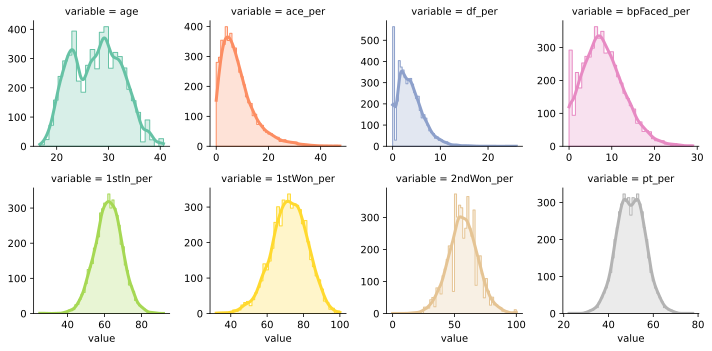

In [51]:
melted_df = tennis_df_long.select_dtypes("float").melt()

grid = sns.FacetGrid(melted_df, col='variable', col_wrap=4, 
                     hue='variable', palette='Set2', 
                     height=2.5, aspect=1,
                     sharex = False, sharey = False)
grid.map(sns.histplot, "value", alpha=.25, 
         kde=True, line_kws={"lw":3}, element="step")

From the above plots, I can see that most of the variables are normally distributed. However, aces and double faults are substantially skewed, with most players making few of either in a match (a large number of players never hit a double fault). Therefore, I'm going to log-transform those variables:

In [52]:
# return the skew of my variables (> |.75| indicates skew that may need transforming)
skew_df = pd.DataFrame(stats.skew(tennis_df_long.select_dtypes("float")),
             index = tennis_df_long.select_dtypes("float").columns)
skew_df.rename(columns={0:"Skew"}, inplace=True)
skew_df.loc[skew_df["Skew"].abs() > .75,'Transform'] = '*'
skew_df

,Skew,Transform
age,9.249811e-02,NaN
ace_per,1.532754e+00,*
df_per,1.171116e+00,*
bpFaced_per,5.728358e-01,NaN
1stIn_per,-9.137607e-02,NaN
1stWon_per,-2.729330e-01,NaN
2ndWon_per,3.562445e-02,NaN
pt_per,6.811701e-17,NaN


In [57]:
# log transform:
log_vars = skew_df.index[skew_df["Transform"]=='*']
for v in log_vars:
    tennis_df_long[v] = stats.boxcox(tennis_df_long[v] + 1)[0] #data must be positive, so add 1                                    

Re-plot the log-transformed values:

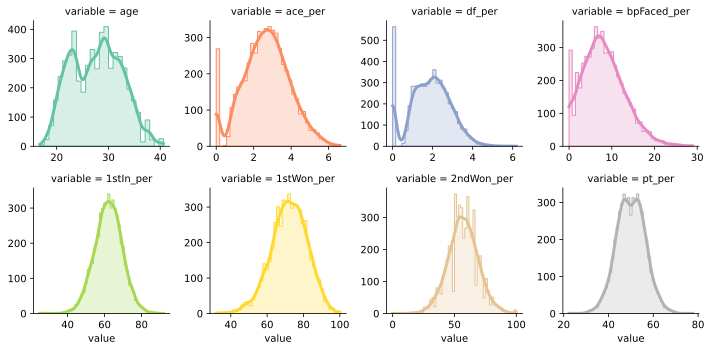

In [58]:
melted_df = tennis_df_long.select_dtypes("float").melt()

grid = sns.FacetGrid(melted_df, col='variable', col_wrap=4, 
                     hue='variable', palette='Set2', 
                     height=2.5, aspect=1,
                     sharex = False, sharey = False)
grid.map(sns.histplot, "value", alpha=.25, 
         kde=True, line_kws={"lw":3}, element="step")

## Outliers

Next, I am checking that there aren't any substantial outliers that might affect linear relationships. To do so, I'm first going to standardize my variables to put them all on an equivalent scale for plotting:

In [59]:
# standardize each of my variables to have equivalent scales:
tennis_df_z = tennis_df_long.copy()
tennis_df_z.loc[:,tennis_df_z.dtypes == "float"] = stats.zscore(tennis_df_z.loc[:,tennis_df_z.dtypes == "float"], axis=0)

To be a bit more liberal with exclusion criteria (so marking fewer data points as outliers), I'm extending the whiskers for the below box plots to 2 * IQR (typically 1.5):

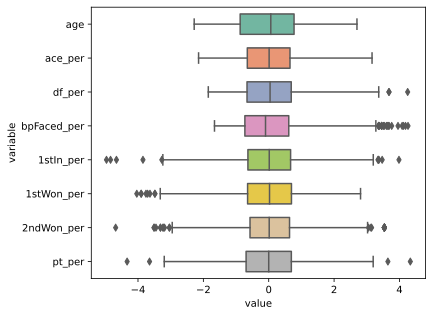

In [60]:
plt.figure(figsize=(6,5))
sns.boxplot(data=tennis_df_z.select_dtypes("float").melt(),
           y = 'variable', x = 'value', palette = "Set2",
           width=.6, whis=2)
plt.show()

Remove outliers from the data:

In [61]:
# data = a pandas series, marks outliers as NaN
def mark_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    my_filter = (data < Q1 - 2 * IQR) | (data > Q3 + 2 * IQR)
    return my_filter

In [62]:
my_vars = tennis_df_long.select_dtypes("float").columns.tolist()
for v in my_vars:
    filt = mark_outliers(tennis_df_long[v])
    tennis_df_long.loc[filt,v] = np.NaN

In [63]:
# drop missing values (outliers):
tennis_df_long.dropna(inplace=True)

print('Cleaned data contains statistics for',tennis_df_long.shape[0],'players\n')
tennis_df_long.head()

Cleaned data contains statistics for 5296 players



,match_id,outcome,name,age,ace_per,df_per,bpFaced_per,1stIn_per,1stWon_per,2ndWon_per,pt_per
0,0,w,Kei Nishikori,29.004791,1.955930,2.123021,7.792208,57.142857,70.454545,56.666667,53.107345
1,1,w,Daniil Medvedev,22.885695,4.510174,1.301106,1.923077,63.461538,84.848485,77.777778,58.914729
2,2,w,Kei Nishikori,29.004791,2.062797,2.247840,4.255319,70.212766,78.787879,75.000000,64.516129
3,3,w,Jo-Wilfried Tsonga,33.705681,4.337238,1.759191,7.352941,63.235294,79.069767,65.217391,55.704698
4,4,w,Daniil Medvedev,22.885695,3.527772,1.724531,7.619048,64.761905,70.588235,73.529412,51.256281


## Save cleaned data

In [68]:
tennis_df_long.to_csv('atp_matches_2019_clean.csv', index=False)

# Key Findings and Insights

In this section, I am using the cleaned data to provide some preliminary insight into how my player variables relate to the likelhood of winning a match as well as the total percentage of points won in a game.

## Data for winners vs. losers

Here are the same histograms as I plotted above, but now divided by whether the player won or lost their match:

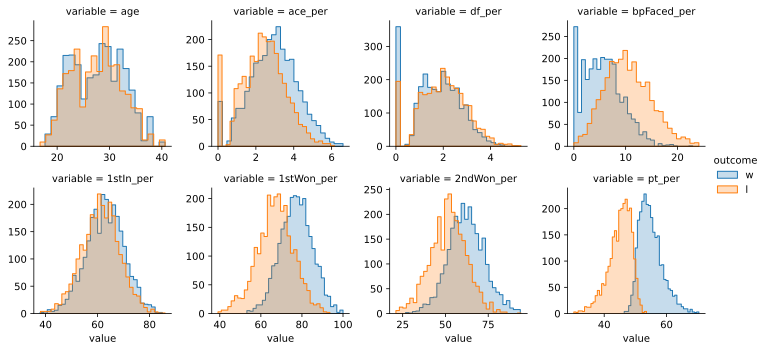

In [64]:
melted_df = tennis_df_long.drop(['match_id','name'], axis=1).melt(id_vars="outcome")

grid = sns.FacetGrid(melted_df, col='variable', col_wrap=4, 
                     hue='outcome', 
                     height=2.5, aspect=1,
                     sharex = False, sharey = False)
grid.map(sns.histplot, "value", alpha=.25, 
         element="step")
grid.add_legend()

Unsurprisingly, players who win the match tend to win a higher percentage of total points ("pt_per"). Visually, what appears to be most strongly associated with the probability of winning is the percentage of aces made in a match, as well as the percentage of 1st and 2nd service points won. Double faults and percentage of 1st serves in appear to make a small contribution, and there appears to be minimal or no impact of age. 

Here is a summary of descriptive statistics, grouped by winners and losers:

In [65]:
tennis_df_long.drop('match_id', axis=1).groupby('outcome').agg(['mean','std','min','max']).transpose()

outcome                   l           w
age         mean  27.565785   27.745019
            std    4.705355    4.889745
            min   16.739220   17.681040
            max   40.624230   40.624230
ace_per     mean   2.402455    2.940446
            std    1.167610    1.244619
            min    0.000000    0.000000
            max    6.160869    6.601074
df_per      mean   1.988309    1.746210
            std    0.987863    1.005898
            min    0.000000    0.000000
            max    5.282612    5.169503
bpFaced_per mean  10.434708    5.653888
            std    4.440393    3.718449
            min    0.000000    0.000000
            max   24.137931   22.950820
1stIn_per   mean  61.211160   62.898193
            std    7.262271    7.267228
            min   38.028169   37.878788
            max   85.964912   84.905660
1stWon_per  mean  67.117094   77.242586
            std    8.851735    7.785057
            min   39.130435   53.191489
            max   93.617021  100.000000
2ndWon_per  mean  51.748970   62.198386
            std   10.567349   10.580892
            min   21.052632   26.666667
            max   94.117647   93.750000
pt_per      mean  45.039198   55.011663
            std    3.743659    3.794582
            min   30.263158   46.428571
            max   53.571429   70.370370

## Correlations

Due to the amount of data, I'm randomly selecting a sub-sample to plot the correlations between my variables:

Randomly sampling data of 150 players



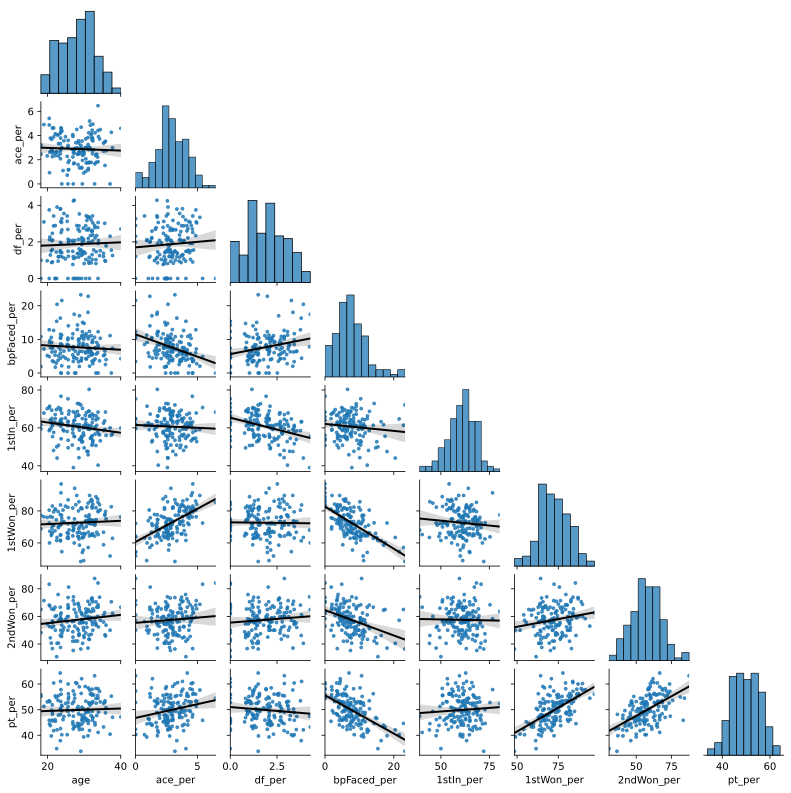

In [66]:
print('Randomly sampling data of 150 players\n')
data_sample = tennis_df_long.sample(150, replace=False)

sns.pairplot(data_sample.select_dtypes("float"),
             kind="reg", height=1.4, corner=True,
             plot_kws={'scatter_kws':{'s':8},
                       'line_kws':{'color':'black',
                                   'lw':2}})
plt.show()

A couple of things to take away from the above plot:    

* none of our feature variables (all apart from pt_per — percentage of game points won) show a particiularly strong correlation with one another, so no real issues with multicollinearity.  

* looking at the bottom row, we confirm the observations above comparing winners and losers — a higher percentage of game points won (pt_per) is positively associated with percentage of 1st serves won, as well as slightly correlated with aces and percentage of 1st serves in, and is slightly negatively associated with the double faults.

# Potential Hypotheses

1. Match winners make a higher percentage of 1st serves than match losers.
2. Match winners are younger than match losers.
3. A higher number of match points won is associated with a higher percentage of 1st serves in. 

# Significance Test: Hypothesis 1

To test the hypothesis that match winners make a higher percentage of 1st serves than match losers, I'm running an independent samples t-test with scipy:

In [26]:
grp1 = tennis_df_long.loc[tennis_df_long["outcome"] == "w","1stIn_per"]
grp2 = tennis_df_long.loc[tennis_df_long["outcome"] == "l","1stIn_per"]
stats.ttest_ind(grp1, grp2)

Ttest_indResult(statistic=6.506143450550752, pvalue=8.541338317664799e-11)

A p value of < .001 shows that winners make a significantly higher % of 1st serves (at alpha = .05) than losers.

# Next Steps

The relationship between percentage of match points won and my continuous features — 1st serves, aces, double faults, etc. — could also be explored separately for winners and losers or based on age categories. For example, perhaps older players benefit (in terms of winning likelihood) from a higher number of aces than younger players? Additionally, you could use classification, such as logistic regression, to predict whether a player will win or lose based on their match statistics. In this case, you could train on half of the data and test on the other half of the data to test the generalisability of the model. Finally, I would be interested in looking at the differences betwen opponents (by match) rather than each player's individual performance — for example, perhaps age becomes important for winning likelihood only when there is a large difference in age between opponents.

# Dataset Quality Summary

Overall, this dataset appears to be good quality. The only variable that had a significant amount of missing data was players' height, which was therefore excluded. Most of the variables are normally diistributed, and relatively few outliers appeared in the data, and there do not appear to be redundancies between the variables (none show a very high correlation). Some additional stats would be useful, including forehand and backhand winners, rally durations, etc., in order to build a comprehensive model of winning likelihood.